# Pseudo Label: Teacher-Student Paradigm with Balanced Generated Data

## Setup

In [1]:
import os
import sys
import random

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K

from PIL import Image
from tensorflow.keras.optimizers import Adam

from project_utils import *
from SatelliteImageData import *

%reload_ext autoreload
%autoreload 2

sys.path.append('../lib/')

random.seed(0)
np.set_printoptions(suppress=True)
weights = [0.001, 0.0033, 0.0053, 0.0015, 0.0003, 0.0002, 0.0088, 0.0248, 0.8125, 0.1423]

K.set_image_data_format('channels_last')
tf.get_logger().setLevel('ERROR')
strategy = tf.distribute.MirroredStrategy()

## Create Dataset

In [2]:
data_root_dir = '../../datasets/dstl-satellite-imagery-feature-detection/'
img_data = SatelliteImageData(data_root_dir)

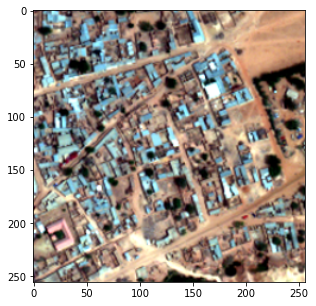

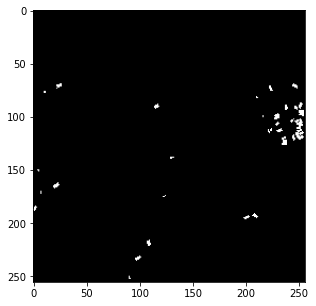

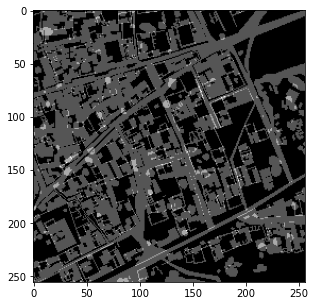

In [3]:
import cv2

temp_img_id = '6120_2_2'
img_size = (1024, 1024)
patch_shape=(256, 256)
patch_coord=(1, 3)

temp_img = img_data.get_visual_m_band_img(temp_img_id)
temp_img = cv2.resize(temp_img, img_size, interpolation=cv2.INTER_LINEAR)
temp_stacked_masks = img_data.get_stacked_masks(img_size, temp_img_id)

temp_img_patch = get_patch(temp_img, patch_shape, patch_coord)
temp_masks_patch = get_patch(temp_stacked_masks, patch_shape, patch_coord)

display_rgb_img(temp_img_patch)
display_mask(temp_masks_patch[:,:,9])
display_stacked_masks(temp_masks_patch)

temp_p_img = img_data.get_m_band_img(temp_img_id)
temp_p_img = img_data.stretch_n_bit(temp_p_img)
temp_p_img = cv2.resize(temp_p_img, img_size, interpolation=cv2.INTER_LINEAR)
temp_p_img_patch = get_patch(temp_p_img, patch_shape, patch_coord)
temp_p_img_patch = temp_p_img_patch[np.newaxis, ...]

## Teacher Model

### Create Teacher Model

In [4]:
from image_segmentation_keras.keras_segmentation.models.fcn import fcn_8_vgg

with strategy.scope():
    teacher_model = fcn_8_vgg(
        input_height=256,
        input_width=256,
        input_channels=8,
        n_classes=10
    )

    teacher_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=weighted_categorical_crossentropy(weights),
        metrics=['accuracy', calc_mean_iou]
    )

teacher_model.load_weights('saved_weights/baseline_weights/fcn_base.h5')

### Generate Psudo Labels with Teacher Model

In [5]:
unlabelled_patch_ids = list(np.load(img_data.processed_data_dir + 'unlabelled_patch_ids.npy'))
Path(img_data.processed_data_dir + 'teacher_model_msks/').mkdir(parents=True, exist_ok=True)

for i, img_id in enumerate(unlabelled_patch_ids):
    if os.path.isfile(img_data.processed_data_dir + 'teacher_model_msks/{}.npy'.format(img_id)):
        continue
    
    if (i/len(unlabelled_patch_ids)*100)%10 == 0:
        print(i, '/', len(unlabelled_patch_ids))
    
    temp_img_patch = np.load(img_data.processed_data_dir + 'imgs/{}.npy'.format(img_id))
    temp_img_patch = temp_img_patch[np.newaxis, ...]
    
    y_pred = teacher_model.predict(temp_img_patch)
    y_pred_mask = y_pred[0]
    y_pred_mask[y_pred_mask > 0.3] = 1
    y_pred_mask[y_pred_mask <= 0.3] = 0
    
    np.save(img_data.processed_data_dir + 'teacher_model_msks/{}.npy'.format(img_id), y_pred_mask)

### Balance Generated Data

In [6]:
if not os.path.isfile(img_data.processed_data_dir + 'teacher_model_labelled_patch_ids.npy'):
    balanced_unlabelled_patch_ids = []
    selected_classes = [1,2,6,7,8,9]
    
    for i, img_id in enumerate(unlabelled_patch_ids):
        if (i/len(unlabelled_patch_ids)*100)%10 == 0:
            print(i, '/', len(unlabelled_patch_ids))
        
        loaded_masks = np.load(img_data.processed_data_dir + 'teacher_model_msks/{}.npy'.format(img_id))

        if (np.sum(loaded_masks[:,:,selected_classes]) > 0
        and np.sum(loaded_masks[:,:,4])/np.sum(loaded_masks) <= 0.5
        and np.sum(loaded_masks[:,:,5])/np.sum(loaded_masks) <= 0.5):
            balanced_unlabelled_patch_ids.append(img_id)

    np.save(img_data.processed_data_dir + 'teacher_model_labelled_patch_ids.npy', balanced_unlabelled_patch_ids)

In [7]:
labelled_patch_ids = list(np.load(img_data.processed_data_dir + 'labelled_patch_ids.npy'))
teacher_model_labelled_patch_ids = list(np.load(img_data.processed_data_dir + 'teacher_model_labelled_patch_ids.npy'))
print(len(labelled_patch_ids))
print(len(teacher_model_labelled_patch_ids))

400
1008


### Create Data Generator From Teacher Model Generate Data

In [8]:
teacher_data_generator = SlicedSatelliteDataGenerator(
    img_data.processed_data_dir,
    teacher_model_labelled_patch_ids,
    input_shape=(256,256,8),
    num_classes=10,
    batch_size=10,
    psudo_label_path=img_data.processed_data_dir + 'teacher_model_msks/'
)

### Create Data Generators From Labelled Data

In [9]:
random.shuffle(labelled_patch_ids)
splitted_id_list = split_list(labelled_patch_ids, split_ratio=(0.8, 0.1, 0.1))

data_generators = []
for id_list in splitted_id_list:
    data_generators.append(SlicedSatelliteDataGenerator(img_data.processed_data_dir,
                                                        id_list,
                                                        input_shape=(256,256,8),
                                                        num_classes=10,
                                                        batch_size=10))

## Student Models

### UNet

In [10]:
from keras_unet.models import satellite_unet

with strategy.scope():
    unet_model = satellite_unet(
        input_shape=(256, 256, 8),
        num_classes=10,
    )

    unet_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=weighted_categorical_crossentropy(weights),
        # metrics=[calc_mean_iou],
        metrics=['accuracy', calc_mean_iou]
    )

# unet_history_0 = unet_model.fit(
#     teacher_data_generator,
#     epochs=100,
#     validation_data=data_generators[1]
# )

# unet_history_1 = unet_model.fit(
#     data_generators[0],
#     epochs=100,
#     validation_data=data_generators[1]
# )

# plt.plot(unet_history_0.history['loss'])
# plt.show()
# plt.plot(unet_history_1.history['loss'])
# plt.show()

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [11]:
# unet_model.save_weights('saved_weights/unet_ts_balanced.h5')

4/4 [==============================] - 0s 89ms/step - loss: 9.8400e-04 - accuracy: 0.3950 - calc_mean_iou: 0.1564
tf.Tensor(
[0.16409779 0.02476003 0.1982182  0.04285187 0.33724034 0.4596678
 0.22929898 0.10758176 0.00002644 0.00015642], shape=(10,), dtype=float32)
0.15638995


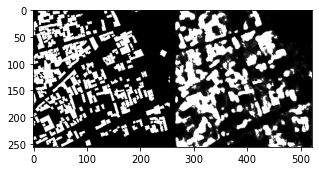

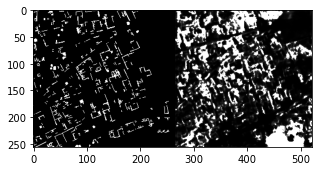

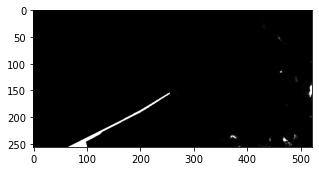

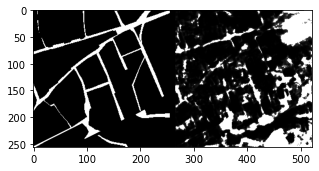

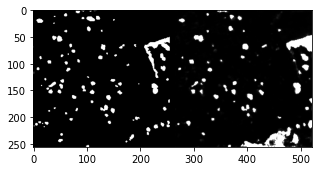

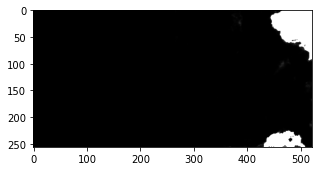

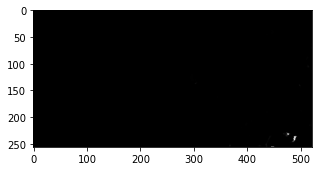

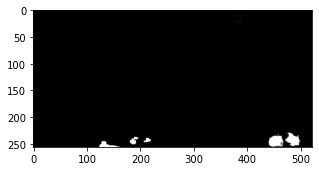

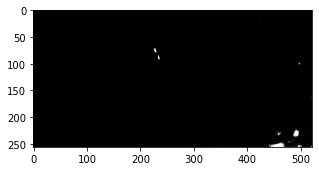

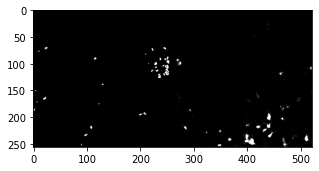

In [12]:
unet_model.load_weights('saved_weights/balanced_teacher_student_weights/unet_ts_balanced.h5')

unet_model.evaluate(data_generators[2])
iou = evaluate_iou(data_generators[2], unet_model)
print(iou)
print(np.mean(iou))

unet_prediction = unet_model.predict(temp_p_img_patch)
unet_tmp_p_masks = unet_prediction[0]
unet_tmp_p_masks[unet_tmp_p_masks > 0.3] = 1

for i in range(10):
    maerged_mask = np.concatenate([temp_masks_patch[:,:,i], np.zeros((256,10)), unet_tmp_p_masks[:,:,i]], axis=1)
    display_mask(maerged_mask)

### FCN

In [13]:
from image_segmentation_keras.keras_segmentation.models.fcn import fcn_8_vgg

with strategy.scope():
    fcn_model = fcn_8_vgg(
        input_height=256,
        input_width=256,
        input_channels=8,
        n_classes=10
    )

    fcn_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=weighted_categorical_crossentropy(weights),
        # metrics=[calc_mean_iou],
        metrics=['accuracy', calc_mean_iou]
    )

# fcn_history_0 = fcn_model.fit(
#     teacher_data_generator,
#     epochs=100,
#     validation_data=data_generators[1]
# )

# fcn_history_1 = fcn_model.fit(
#     data_generators[0],
#     epochs=100,
#     validation_data=data_generators[1]
# )

# plt.plot(fcn_history_0.history['loss'])
# plt.show()
# plt.plot(fcn_history_1.history['loss'])
# plt.show()

In [14]:
# fcn_model.save_weights('saved_weights/fcn_ts_balanced.h5')

4/4 [==============================] - 0s 122ms/step - loss: 4.6994e-04 - accuracy: 0.4178 - calc_mean_iou: 0.2279
tf.Tensor(
[0.3819141  0.038038   0.3562634  0.049326   0.2596046  0.619026
 0.3722242  0.19886723 0.00026933 0.00382939], shape=(10,), dtype=float32)
0.22793624


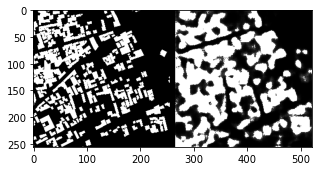

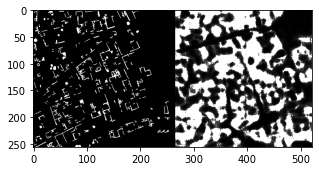

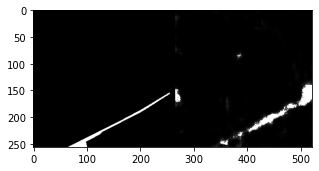

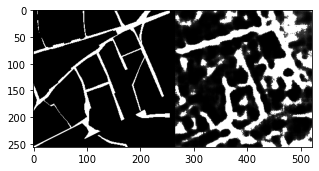

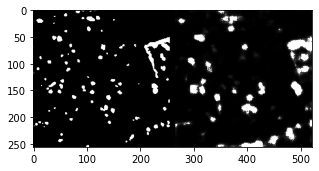

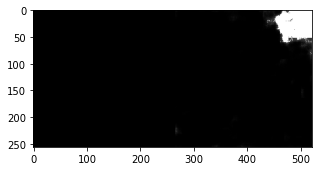

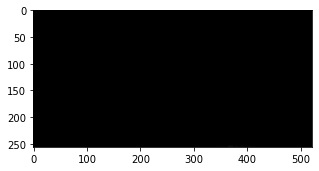

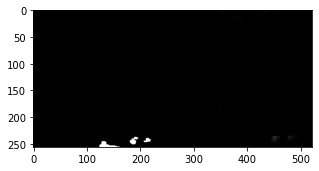

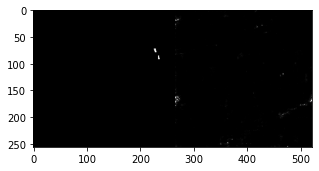

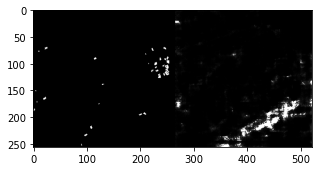

In [15]:
fcn_model.load_weights('saved_weights/balanced_teacher_student_weights/fcn_ts_balanced.h5')

fcn_model.evaluate(data_generators[2])
iou = evaluate_iou(data_generators[2], fcn_model)
print(iou)
print(np.mean(iou))

fcn_prediction = fcn_model.predict(temp_p_img_patch)
fcn_tmp_p_masks = fcn_prediction[0]
fcn_tmp_p_masks[fcn_tmp_p_masks > 0.3] = 1

for i in range(10):
    maerged_mask = np.concatenate([temp_masks_patch[:,:,i], np.zeros((256,10)), fcn_tmp_p_masks[:,:,i]], axis=1)
    display_mask(maerged_mask)

### SegNet

In [16]:
from keras_segnet.segnet import SegNet

with strategy.scope():
    segnet_model = SegNet(
        input_shape=(256, 256, 8),
        classes=10
    )

    segnet_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=weighted_categorical_crossentropy(weights),
        # metrics=[calc_mean_iou],
        metrics=['accuracy', calc_mean_iou]
    )

# segnet_history_0 = segnet_model.fit(
#     teacher_data_generator,
#     epochs=100,
#     validation_data=data_generators[1]
# )

# segnet_history_1 = segnet_model.fit(
#     data_generators[0],
#     epochs=100,
#     validation_data=data_generators[1]
# )

# plt.plot(segnet_history_0.history['loss'])
# plt.show()
# plt.plot(segnet_history_1.history['loss'])
# plt.show()

In [17]:
# segnet_model.save_weights('saved_weights/segnet_ts_balanced.h5')

4/4 [==============================] - 0s 78ms/step - loss: 6.4646e-04 - accuracy: 0.4292 - calc_mean_iou: 0.2012
tf.Tensor(
[0.25528604 0.03256909 0.315233   0.06583893 0.2601433  0.5804452
 0.3687994  0.13365734 0.00003161 0.00021437], shape=(10,), dtype=float32)
0.20122185


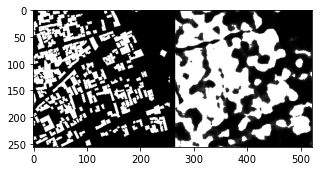

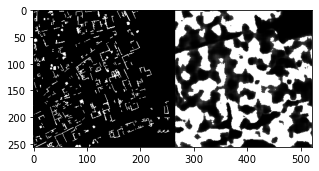

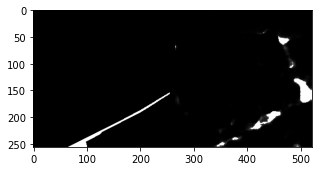

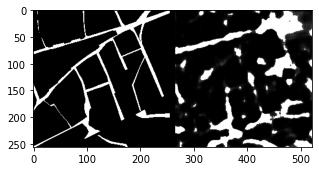

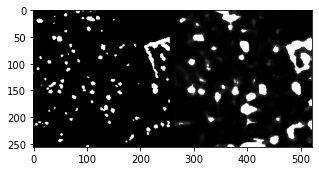

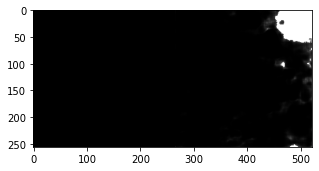

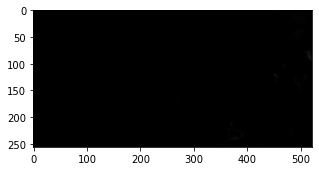

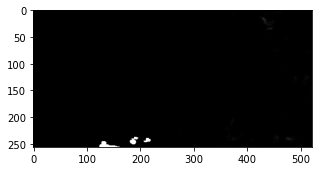

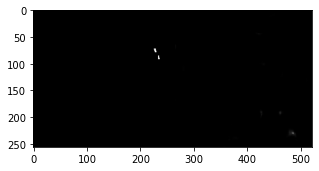

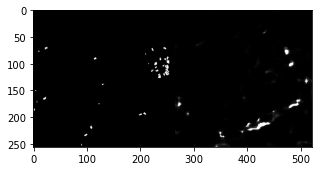

In [18]:
segnet_model.load_weights('saved_weights/balanced_teacher_student_weights/segnet_ts_balanced.h5')

segnet_model.evaluate(data_generators[2])
iou = evaluate_iou(data_generators[2], segnet_model)
print(iou)
print(np.mean(iou))

segnet_prediction = segnet_model.predict(temp_p_img_patch)
segnet_tmp_p_masks = segnet_prediction[0]
segnet_tmp_p_masks[segnet_tmp_p_masks > 0.3] = 1

for i in range(10):
    maerged_mask = np.concatenate([temp_masks_patch[:,:,i], np.zeros((256,10)), segnet_tmp_p_masks[:,:,i]], axis=1)
    display_mask(maerged_mask)

### Deeplab V3 Plus

In [19]:
from keras_deeplab_v3_plus.model import Deeplabv3

with strategy.scope():
    deeplab_model = Deeplabv3(
        weights=None,
        input_shape=(256, 256, 8),
        classes=10,
        activation='softmax',
        backbone='xception',
        OS=16
    )

    deeplab_model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=weighted_categorical_crossentropy(weights),
        # metrics=[calc_mean_iou],
        metrics=['accuracy', calc_mean_iou]
    )

# deeplab_history_0 = deeplab_model.fit(
#     teacher_data_generator,
#     epochs=100,
#     validation_data=data_generators[1]
# )

# deeplab_history_1 = deeplab_model.fit(
#     data_generators[0],
#     epochs=100,
#     validation_data=data_generators[1]
# )

# plt.plot(deeplab_history_0.history['loss'])
# plt.show()
# plt.plot(deeplab_history_1.history['loss'])
# plt.show()

In [20]:
# deeplab_model.save_weights('saved_weights/deeplab_ts_balanced.h5')

4/4 [==============================] - 0s 125ms/step - loss: 8.3438e-04 - accuracy: 0.4195 - calc_mean_iou: 0.1473
tf.Tensor(
[0.08950409 0.01737561 0.16830347 0.04428612 0.24427679 0.5459809
 0.23641957 0.12605011 0.00025246 0.00017532], shape=(10,), dtype=float32)
0.14726244


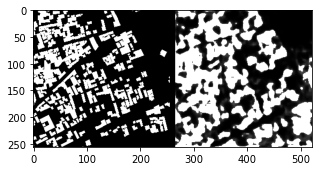

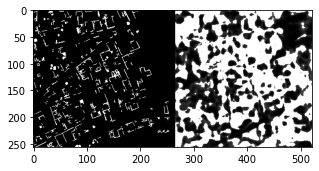

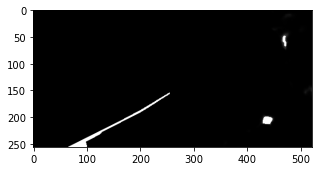

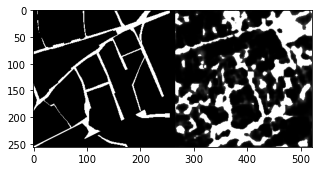

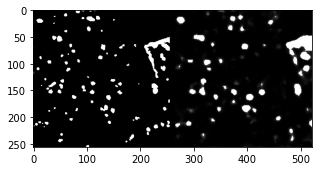

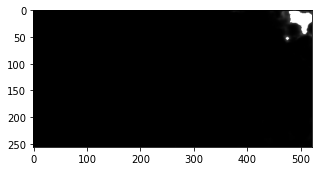

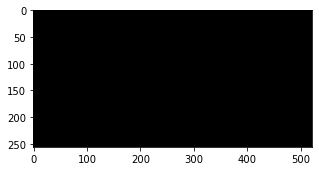

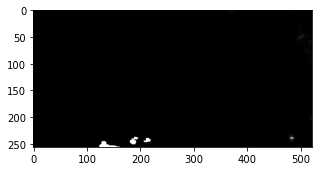

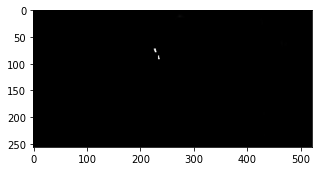

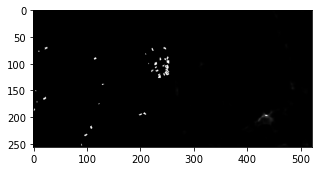

In [21]:
deeplab_model.load_weights('saved_weights/balanced_teacher_student_weights/deeplab_ts_balanced.h5')

deeplab_model.evaluate(data_generators[2])
iou = evaluate_iou(data_generators[2], deeplab_model)
print(iou)
print(np.mean(iou))

deeplab_prediction = deeplab_model.predict(temp_p_img_patch)
deeplab_tmp_p_masks = deeplab_prediction[0]
deeplab_tmp_p_masks[deeplab_tmp_p_masks > 0.3] = 1

for i in range(10):
    maerged_mask = np.concatenate([temp_masks_patch[:,:,i], np.zeros((256,10)), deeplab_tmp_p_masks[:,:,i]], axis=1)
    display_mask(maerged_mask)